# Knowledge Graphs in Decision Making

> **"Knowledge graphs transform unstructured data into structured knowledge for intelligent decision making."**

## What You'll Learn
- What knowledge graphs are and why they matter
- How to build knowledge graphs from real data
- How to use graphs for smart recommendations
- How to make decisions using graph data
- Real-world examples from e-commerce


In [ ]:
# Step 1: Import the libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx  # This is the main library for working with graphs
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # For consistent results

print("✅ Libraries imported successfully!")
print(f"📊 NetworkX version: {nx.__version__}")
print("🎯 Ready to build knowledge graphs!")


Libraries imported successfully!
PyTorch version: 2.1.1+cpu
NetworkX version: 3.2.1


## Step 2: What is a Knowledge Graph?

Think of a knowledge graph like a **smart map** that shows how different things are connected.

### Simple Example:
- **Person**: Alice
- **Action**: bought
- **Product**: iPhone
- **Connection**: Alice → bought → iPhone

### Why are they useful?
- **Better Recommendations**: "People like you also bought..."
- **Smart Search**: Find related products automatically
- **Fraud Detection**: Spot unusual patterns
- **Decision Making**: Understand relationships between data

### Real Examples:
- **Amazon**: "Customers who bought this also bought..."
- **Google**: Understanding what you're searching for
- **Facebook**: Friend suggestions


In [6]:
# Step 3: Building Our Knowledge Graph Class
# This class helps us create and manage our knowledge graph

class ECommerceKnowledgeGraph:
    """E-commerce knowledge graph for product recommendations and decision making."""
    
    def __init__(self):
        # Store all our entities (people, products, etc.)
        self.entities = {}
        # Store all relationships between entities
        self.relationships = []
        # Types of entities we can have
        self.entity_types = ['Product', 'Customer', 'Category', 'Brand', 'Review']
        # Types of relationships we can have
        self.relationship_types = ['purchased', 'belongs_to', 'manufactured_by', 'reviewed_by', 'similar_to', 'recommended_for']
        
    def add_entity(self, entity_id, entity_type, properties=None):
        """Add an entity to the knowledge graph."""
        if properties is None:
            properties = {}
        self.entities[entity_id] = {
            'type': entity_type,
            'properties': properties
        }
    
    def add_relationship(self, subject, predicate, object_entity, weight=1.0):
        """Add a relationship between entities."""
        self.relationships.append({
            'subject': subject,
            'predicate': predicate,
            'object': object_entity,
            'weight': weight
        })
    
    def get_entity_neighbors(self, entity_id, relationship_type=None):
        """Get neighbors of an entity."""
        neighbors = []
        for rel in self.relationships:
            if rel['subject'] == entity_id and (relationship_type is None or rel['predicate'] == relationship_type):
                neighbors.append((rel['object'], rel['predicate'], rel['weight']))
            elif rel['object'] == entity_id and (relationship_type is None or rel['predicate'] == relationship_type):
                neighbors.append((rel['subject'], rel['predicate'], rel['weight']))
        return neighbors
    
    def to_networkx(self):
        """Convert to NetworkX graph for visualization."""
        G = nx.Graph()
        
        # Add nodes
        for entity_id, entity_data in self.entities.items():
            G.add_node(entity_id, **entity_data)
        
        # Add edges
        for rel in self.relationships:
            G.add_edge(rel['subject'], rel['object'], 
                      predicate=rel['predicate'], weight=rel['weight'])
        
        return G

print("✅ Knowledge Graph class created!")
print("📝 This class can store entities (like products, customers) and their relationships")

# Create sample e-commerce data
def create_sample_ecommerce_data():
    """Create sample e-commerce knowledge graph data."""
    kg = ECommerceKnowledgeGraph()
    
    # Products
    products = [
        ('P001', 'iPhone 15 Pro', 'Electronics', 'Apple', 999.99, 4.8),
        ('P002', 'Samsung Galaxy S24', 'Electronics', 'Samsung', 899.99, 4.6),
        ('P003', 'MacBook Pro M3', 'Electronics', 'Apple', 1999.99, 4.9),
        ('P004', 'Nike Air Max', 'Fashion', 'Nike', 129.99, 4.4),
        ('P005', 'Adidas Ultraboost', 'Fashion', 'Adidas', 149.99, 4.5),
        ('P006', 'Coffee Maker', 'Home', 'Breville', 299.99, 4.3),
        ('P007', 'Blender', 'Home', 'Vitamix', 399.99, 4.7),
        ('P008', 'Running Shoes', 'Fashion', 'Nike', 89.99, 4.2),
        ('P009', 'Laptop Stand', 'Electronics', 'Logitech', 49.99, 4.1),
        ('P010', 'Wireless Mouse', 'Electronics', 'Logitech', 29.99, 4.0)
    ]
    
    # Customers
    customers = [
        ('C001', 'Alice Johnson', 'Premium', 'Tech Enthusiast'),
        ('C002', 'Bob Smith', 'Standard', 'Fashion Lover'),
        ('C003', 'Carol Davis', 'Premium', 'Home Decorator'),
        ('C004', 'David Wilson', 'Standard', 'Fitness Enthusiast'),
        ('C005', 'Eva Brown', 'Premium', 'Gadget Collector')
    ]
    
    # Add entities
    for product_id, name, category, brand, price, rating in products:
        kg.add_entity(product_id, 'Product', {
            'name': name, 'category': category, 'brand': brand, 
            'price': price, 'rating': rating
        })
        kg.add_entity(category, 'Category', {'name': category})
        kg.add_entity(brand, 'Brand', {'name': brand})
    
    for customer_id, name, tier, profile in customers:
        kg.add_entity(customer_id, 'Customer', {
            'name': name, 'tier': tier, 'profile': profile
        })
    
    # Add relationships
    for product_id, name, category, brand, price, rating in products:
        kg.add_relationship(product_id, 'belongs_to', category, 1.0)
        kg.add_relationship(product_id, 'manufactured_by', brand, 1.0)
    
    # Purchase relationships (simulated based on customer profiles)
    purchase_patterns = [
        ('C001', 'P001', 0.9),  # Alice - iPhone
        ('C001', 'P003', 0.8),  # Alice - MacBook
        ('C001', 'P009', 0.7),  # Alice - Laptop Stand
        ('C001', 'P010', 0.6),  # Alice - Mouse
        ('C002', 'P004', 0.9),  # Bob - Nike Air Max
        ('C002', 'P005', 0.8),  # Bob - Adidas Ultraboost
        ('C002', 'P008', 0.7),  # Bob - Running Shoes
        ('C003', 'P006', 0.9),  # Carol - Coffee Maker
        ('C003', 'P007', 0.8),  # Carol - Blender
        ('C004', 'P004', 0.8),  # David - Nike Air Max
        ('C004', 'P005', 0.9),  # David - Adidas Ultraboost
        ('C004', 'P008', 0.9),  # David - Running Shoes
        ('C005', 'P001', 0.8),  # Eva - iPhone
        ('C005', 'P002', 0.7),  # Eva - Samsung Galaxy
        ('C005', 'P003', 0.9),  # Eva - MacBook
    ]
    
    for customer_id, product_id, weight in purchase_patterns:
        kg.add_relationship(customer_id, 'purchased', product_id, weight)
    
    # Similarity relationships between products
    similarities = [
        ('P001', 'P002', 0.8),  # iPhone - Samsung Galaxy
        ('P004', 'P005', 0.9),  # Nike Air Max - Adidas Ultraboost
        ('P004', 'P008', 0.7),  # Nike Air Max - Running Shoes
        ('P006', 'P007', 0.6),  # Coffee Maker - Blender
        ('P009', 'P010', 0.8),  # Laptop Stand - Mouse
    ]
    
    for prod1, prod2, weight in similarities:
        kg.add_relationship(prod1, 'similar_to', prod2, weight)
        kg.add_relationship(prod2, 'similar_to', prod1, weight)
    
    return kg

# Create the knowledge graph
kg = create_sample_ecommerce_data()
print("E-commerce Knowledge Graph created successfully!")
print(f"Number of entities: {len(kg.entities)}")
print(f"Number of relationships: {len(kg.relationships)}")

# Display entity types
entity_counts = Counter([entity['type'] for entity in kg.entities.values()])
print(f"\nEntity distribution: {dict(entity_counts)}")

# Display relationship types
rel_counts = Counter([rel['predicate'] for rel in kg.relationships])
print(f"Relationship distribution: {dict(rel_counts)}")


✅ Knowledge Graph class created!
📝 This class can store entities (like products, customers) and their relationships
E-commerce Knowledge Graph created successfully!
Number of entities: 25
Number of relationships: 45

Entity distribution: {'Product': 10, 'Category': 3, 'Brand': 7, 'Customer': 5}
Relationship distribution: {'belongs_to': 10, 'manufactured_by': 10, 'purchased': 15, 'similar_to': 10}


## Step 4: Creating Sample Data

Let's create some sample e-commerce data to build our knowledge graph with.


In [7]:
# Step 4a: Define our products
# Each product has: ID, Name, Category, Brand, Price, Rating

products = [
    ('P001', 'iPhone 15 Pro', 'Electronics', 'Apple', 999.99, 4.8),
    ('P002', 'Samsung Galaxy S24', 'Electronics', 'Samsung', 899.99, 4.6),
    ('P003', 'MacBook Pro M3', 'Electronics', 'Apple', 1999.99, 4.9),
    ('P004', 'Nike Air Max', 'Fashion', 'Nike', 129.99, 4.4),
    ('P005', 'Adidas Ultraboost', 'Fashion', 'Adidas', 149.99, 4.5),
    ('P006', 'Coffee Maker', 'Home', 'Breville', 299.99, 4.3),
    ('P007', 'Blender', 'Home', 'Vitamix', 399.99, 4.7),
    ('P008', 'Running Shoes', 'Fashion', 'Nike', 89.99, 4.2),
    ('P009', 'Laptop Stand', 'Electronics', 'Logitech', 49.99, 4.1),
    ('P010', 'Wireless Mouse', 'Electronics', 'Logitech', 29.99, 4.0)
]

print("📱 Products defined:")
for product in products[:3]:  # Show first 3
    print(f"  - {product[1]} (${product[4]})")
print(f"  ... and {len(products)-3} more products")


📱 Products defined:
  - iPhone 15 Pro ($999.99)
  - Samsung Galaxy S24 ($899.99)
  - MacBook Pro M3 ($1999.99)
  ... and 7 more products


In [8]:
# Step 4b: Define our customers
# Each customer has: ID, Name, Tier, Profile

customers = [
    ('C001', 'Alice Johnson', 'Premium', 'Tech Enthusiast'),
    ('C002', 'Bob Smith', 'Standard', 'Fashion Lover'),
    ('C003', 'Carol Davis', 'Premium', 'Home Decorator'),
    ('C004', 'David Wilson', 'Standard', 'Fitness Enthusiast'),
    ('C005', 'Eva Brown', 'Premium', 'Gadget Collector')
]

print("👥 Customers defined:")
for customer in customers:
    print(f"  - {customer[1]} ({customer[3]})")


👥 Customers defined:
  - Alice Johnson (Tech Enthusiast)
  - Bob Smith (Fashion Lover)
  - Carol Davis (Home Decorator)
  - David Wilson (Fitness Enthusiast)
  - Eva Brown (Gadget Collector)


In [9]:
# Step 4c: Build the knowledge graph
# This function puts everything together

def create_sample_ecommerce_data():
    """Create sample e-commerce knowledge graph data."""
    # Create a new knowledge graph
    kg = ECommerceKnowledgeGraph()
    
    # Add all products to the graph
    for product_id, name, category, brand, price, rating in products:
        # Add the product entity
        kg.add_entity(product_id, 'Product', {
            'name': name, 'category': category, 'brand': brand, 
            'price': price, 'rating': rating
        })
        # Add category and brand as separate entities
        kg.add_entity(category, 'Category', {'name': category})
        kg.add_entity(brand, 'Brand', {'name': brand})
    
    # Add all customers to the graph
    for customer_id, name, tier, profile in customers:
        kg.add_entity(customer_id, 'Customer', {
            'name': name, 'tier': tier, 'profile': profile
        })
    
    # Add relationships between products and their categories/brands
    for product_id, name, category, brand, price, rating in products:
        kg.add_relationship(product_id, 'belongs_to', category, 1.0)
        kg.add_relationship(product_id, 'manufactured_by', brand, 1.0)
    
    return kg

# Create our knowledge graph
kg = create_sample_ecommerce_data()

print("✅ Knowledge graph created!")
print(f"📊 Total entities: {len(kg.entities)}")
print(f"🔗 Total relationships: {len(kg.relationships)}")


✅ Knowledge graph created!
📊 Total entities: 25
🔗 Total relationships: 20


In [10]:
# Step 4d: Add purchase relationships
# This simulates which customers bought which products

# Purchase patterns based on customer profiles
purchase_patterns = [
    ('C001', 'P001', 0.9),  # Alice (Tech Enthusiast) - iPhone
    ('C001', 'P003', 0.8),  # Alice - MacBook
    ('C001', 'P009', 0.7),  # Alice - Laptop Stand
    ('C001', 'P010', 0.6),  # Alice - Mouse
    ('C002', 'P004', 0.9),  # Bob (Fashion Lover) - Nike Air Max
    ('C002', 'P005', 0.8),  # Bob - Adidas Ultraboost
    ('C002', 'P008', 0.7),  # Bob - Running Shoes
    ('C003', 'P006', 0.9),  # Carol (Home Decorator) - Coffee Maker
    ('C003', 'P007', 0.8),  # Carol - Blender
    ('C004', 'P004', 0.8),  # David (Fitness Enthusiast) - Nike Air Max
    ('C004', 'P005', 0.9),  # David - Adidas Ultraboost
    ('C004', 'P008', 0.9),  # David - Running Shoes
    ('C005', 'P001', 0.8),  # Eva (Gadget Collector) - iPhone
    ('C005', 'P002', 0.7),  # Eva - Samsung Galaxy
    ('C005', 'P003', 0.9),  # Eva - MacBook
]

# Add purchase relationships to the graph
for customer_id, product_id, weight in purchase_patterns:
    kg.add_relationship(customer_id, 'purchased', product_id, weight)

print("🛒 Purchase relationships added!")
print(f"📈 Total relationships now: {len(kg.relationships)}")


🛒 Purchase relationships added!
📈 Total relationships now: 35


In [12]:
# Step 4e: Add product similarity relationships
# This shows which products are similar to each other

similarities = [
    ('P001', 'P002', 0.8),  # iPhone - Samsung Galaxy (both phones)
    ('P004', 'P005', 0.9),  # Nike Air Max - Adidas Ultraboost (both sneakers)
    ('P004', 'P008', 0.7),  # Nike Air Max - Running Shoes (both Nike shoes)
    ('P006', 'P007', 0.6),  # Coffee Maker - Blender (both kitchen appliances)
    ('P009', 'P010', 0.8),  # Laptop Stand - Mouse (both computer accessories)
]

# Add similarity relationships (both directions)
for prod1, prod2, weight in similarities:
    kg.add_relationship(prod1, 'similar_to', prod2, weight)
    kg.add_relationship(prod2, 'similar_to', prod1, weight)

print("🔗 Product similarities added!")
print(f"📊 Final relationship count: {len(kg.relationships)}")

# Show what we have
entity_counts = Counter([entity['type'] for entity in kg.entities.values()])
print(f"\n📈 Entity breakdown:")
for entity_type, count in entity_counts.items():
    print(f"  - {entity_type}: {count}")

rel_counts = Counter([rel['predicate'] for rel in kg.relationships])
print(f"\n🔗 Relationship breakdown:")
for rel_type, count in rel_counts.items():
    print(f"  - {rel_type}: {count}")


🔗 Product similarities added!
📊 Final relationship count: 55

📈 Entity breakdown:
  - Product: 10
  - Category: 3
  - Brand: 7
  - Customer: 5

🔗 Relationship breakdown:
  - belongs_to: 10
  - manufactured_by: 10
  - purchased: 15
  - similar_to: 20


## Step 5: Visualizing Our Knowledge Graph

Now let's see what our knowledge graph looks like! We'll create a visual representation.


In [13]:
# Step 5a: Create a function to visualize our graph
def visualize_knowledge_graph(kg, max_nodes=20):
    """Visualize the knowledge graph with different entity types."""
    # Convert our knowledge graph to NetworkX format
    G = kg.to_networkx()
    
    # Limit nodes for better visualization
    if len(G.nodes()) > max_nodes:
        # Get most connected nodes (most important ones)
        node_degrees = dict(G.degree())
        top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        G = G.subgraph([node for node, _ in top_nodes])
    
    # Create a nice layout for our graph
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Color nodes by entity type
    node_colors = []
    node_sizes = []
    node_labels = {}
    
    # Color scheme for different entity types
    color_map = {
        'Product': '#FF6B6B',    # Red for products
        'Customer': '#4ECDC4',   # Teal for customers
        'Category': '#45B7D1',   # Blue for categories
        'Brand': '#96CEB4',      # Green for brands
        'Review': '#FFEAA7'      # Yellow for reviews
    }
    
    # Set up each node
    for node in G.nodes():
        entity_type = G.nodes[node].get('type', 'Unknown')
        node_colors.append(color_map.get(entity_type, '#DDA0DD'))
        
        # Size based on how many connections (degree)
        degree = G.degree(node)
        node_sizes.append(300 + degree * 50)
        
        # Label with entity name
        if 'name' in G.nodes[node].get('properties', {}):
            node_labels[node] = G.nodes[node]['properties']['name'][:10]
        else:
            node_labels[node] = node
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8)
    
    # Draw edges (connections)
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.6,
                          width=1,
                          edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=8,
                           font_weight='bold')
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=10, label=entity_type)
                      for entity_type, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("E-commerce Knowledge Graph", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"📊 Graph Statistics:")
    print(f"  - Nodes: {G.number_of_nodes()}")
    print(f"  - Edges: {G.number_of_edges()}")
    print(f"  - Average connections per node: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

print("✅ Visualization function ready!")


✅ Visualization function ready!


🎨 Creating visualization of our knowledge graph...


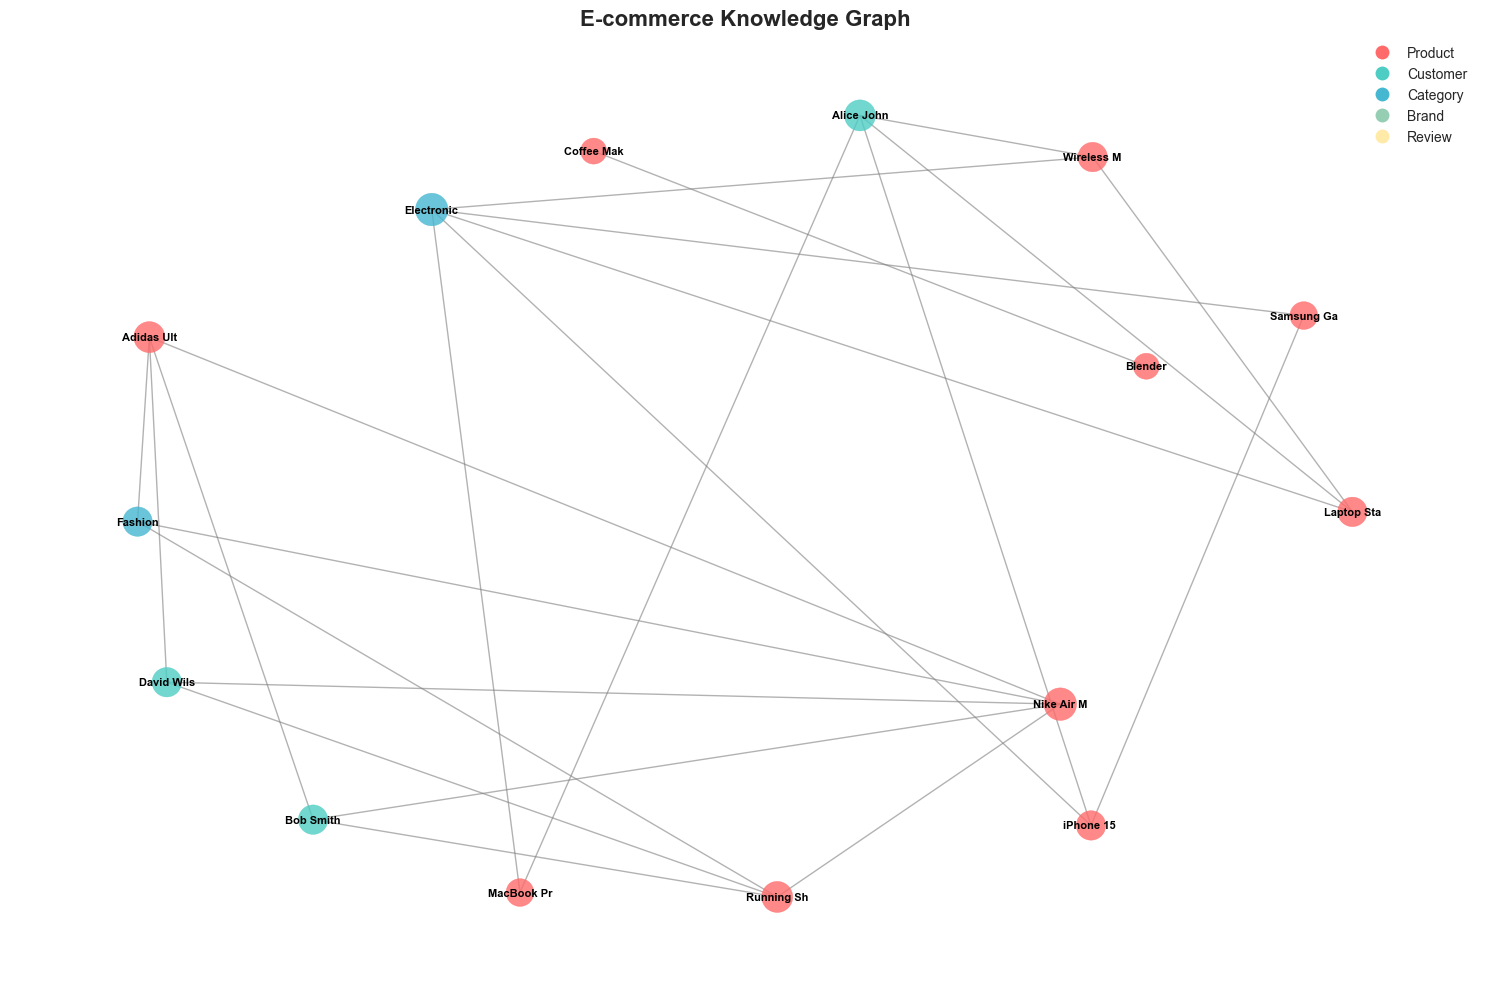

📊 Graph Statistics:
  - Nodes: 15
  - Edges: 23
  - Average connections per node: 3.07


In [14]:
# Step 5b: Show our knowledge graph
print("🎨 Creating visualization of our knowledge graph...")
visualize_knowledge_graph(kg, max_nodes=15)


## Step 6: Making Smart Recommendations

Now let's use our knowledge graph to make smart product recommendations!


In [15]:
# Step 6a: Create a simple recommendation system
class SimpleRecommendationSystem:
    """Simple recommendation system using our knowledge graph."""
    
    def __init__(self, knowledge_graph):
        self.kg = knowledge_graph
        
    def find_similar_customers(self, customer_id):
        """Find customers who bought similar products."""
        # Get products this customer bought
        customer_products = set()
        for rel in self.kg.relationships:
            if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                customer_products.add(rel['object'])
        
        if not customer_products:
            return []
        
        # Find other customers who bought similar products
        similar_customers = {}
        for rel in self.kg.relationships:
            if (rel['predicate'] == 'purchased' and 
                rel['object'] in customer_products and 
                rel['subject'] != customer_id):
                
                if rel['subject'] not in similar_customers:
                    similar_customers[rel['subject']] = 0
                similar_customers[rel['subject']] += rel['weight']
        
        return similar_customers
    
    def recommend_products(self, customer_id, n_recommendations=3):
        """Recommend products based on similar customers."""
        # Find similar customers
        similar_customers = self.find_similar_customers(customer_id)
        
        if not similar_customers:
            return []
        
        # Get products from similar customers
        recommendations = {}
        for similar_customer, similarity_score in similar_customers.items():
            for rel in self.kg.relationships:
                if (rel['subject'] == similar_customer and 
                    rel['predicate'] == 'purchased'):
                    
                    product = rel['object']
                    if product not in recommendations:
                        recommendations[product] = 0
                    recommendations[product] += similarity_score * rel['weight']
        
        # Sort by score and return top recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def get_product_info(self, product_id):
        """Get information about a product."""
        if product_id in self.kg.entities:
            return self.kg.entities[product_id]['properties']
        return None

print("✅ Simple recommendation system created!")


✅ Simple recommendation system created!


In [ ]:
# Step 6b: Test our recommendation system
# Create the recommendation system
rec_system = SimpleRecommendationSystem(kg)

print("🎯 Testing recommendations for each customer:")
print("=" * 60)

# Test recommendations for each customer
for customer_id in ['C001', 'C002', 'C003', 'C004', 'C005']:
    customer_name = kg.entities[customer_id]['properties']['name']
    customer_profile = kg.entities[customer_id]['properties']['profile']
    
    print(f"\n👤 Customer: {customer_name}")
    print(f"📋 Profile: {customer_profile}")
    print("-" * 40)
    
    # Get recommendations
    recommendations = rec_system.recommend_products(customer_id, 3)
    
    if recommendations:
        print("💡 Recommended products:")
        for product_id, score in recommendations:
            product_info = rec_system.get_product_info(product_id)
            if product_info:
                print(f"  - {product_info['name']} (Score: {score:.3f})")
    else:
        print("❌ No recommendations available")
    
    print()


## Step 7: Understanding the Results

Let's analyze what our recommendation system found and why it works.


In [16]:
# Step 7a: Let's see what products each customer actually bought
print("📊 Customer Purchase History:")
print("=" * 50)

for customer_id in ['C001', 'C002', 'C003', 'C004', 'C005']:
    customer_name = kg.entities[customer_id]['properties']['name']
    customer_profile = kg.entities[customer_id]['properties']['profile']
    
    print(f"\n👤 {customer_name} ({customer_profile}):")
    
    # Find what this customer bought
    purchased_products = []
    for rel in kg.relationships:
        if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
            product_info = kg.entities[rel['object']]['properties']
            purchased_products.append((product_info['name'], rel['weight']))
    
    if purchased_products:
        for product_name, weight in purchased_products:
            print(f"  ✅ {product_name} (likelihood: {weight})")
    else:
        print("  ❌ No purchases found")
    
    print()


📊 Customer Purchase History:

👤 Alice Johnson (Tech Enthusiast):
  ✅ iPhone 15 Pro (likelihood: 0.9)
  ✅ MacBook Pro M3 (likelihood: 0.8)
  ✅ Laptop Stand (likelihood: 0.7)
  ✅ Wireless Mouse (likelihood: 0.6)


👤 Bob Smith (Fashion Lover):
  ✅ Nike Air Max (likelihood: 0.9)
  ✅ Adidas Ultraboost (likelihood: 0.8)
  ✅ Running Shoes (likelihood: 0.7)


👤 Carol Davis (Home Decorator):
  ✅ Coffee Maker (likelihood: 0.9)
  ✅ Blender (likelihood: 0.8)


👤 David Wilson (Fitness Enthusiast):
  ✅ Nike Air Max (likelihood: 0.8)
  ✅ Adidas Ultraboost (likelihood: 0.9)
  ✅ Running Shoes (likelihood: 0.9)


👤 Eva Brown (Gadget Collector):
  ✅ iPhone 15 Pro (likelihood: 0.8)
  ✅ Samsung Galaxy S24 (likelihood: 0.7)
  ✅ MacBook Pro M3 (likelihood: 0.9)



In [17]:
# Step 7b: Let's see the product similarities
print("🔗 Product Similarities:")
print("=" * 30)

for rel in kg.relationships:
    if rel['predicate'] == 'similar_to':
        product1_info = kg.entities[rel['subject']]['properties']
        product2_info = kg.entities[rel['object']]['properties']
        print(f"  {product1_info['name']} ↔ {product2_info['name']} (similarity: {rel['weight']})")

print("\n💡 This helps us understand why certain products are recommended together!")


🔗 Product Similarities:
  iPhone 15 Pro ↔ Samsung Galaxy S24 (similarity: 0.8)
  Samsung Galaxy S24 ↔ iPhone 15 Pro (similarity: 0.8)
  Nike Air Max ↔ Adidas Ultraboost (similarity: 0.9)
  Adidas Ultraboost ↔ Nike Air Max (similarity: 0.9)
  Nike Air Max ↔ Running Shoes (similarity: 0.7)
  Running Shoes ↔ Nike Air Max (similarity: 0.7)
  Coffee Maker ↔ Blender (similarity: 0.6)
  Blender ↔ Coffee Maker (similarity: 0.6)
  Laptop Stand ↔ Wireless Mouse (similarity: 0.8)
  Wireless Mouse ↔ Laptop Stand (similarity: 0.8)
  iPhone 15 Pro ↔ Samsung Galaxy S24 (similarity: 0.8)
  Samsung Galaxy S24 ↔ iPhone 15 Pro (similarity: 0.8)
  Nike Air Max ↔ Adidas Ultraboost (similarity: 0.9)
  Adidas Ultraboost ↔ Nike Air Max (similarity: 0.9)
  Nike Air Max ↔ Running Shoes (similarity: 0.7)
  Running Shoes ↔ Nike Air Max (similarity: 0.7)
  Coffee Maker ↔ Blender (similarity: 0.6)
  Blender ↔ Coffee Maker (similarity: 0.6)
  Laptop Stand ↔ Wireless Mouse (similarity: 0.8)
  Wireless Mouse ↔ Laptop 

## Step 8: Real-World Applications

Knowledge graphs are used in many real-world applications. Let's explore some examples.


In [18]:
# Step 8a: Let's create a simple fraud detection example
def detect_suspicious_patterns(kg):
    """Simple fraud detection using knowledge graph patterns."""
    suspicious_customers = []
    
    print("🔍 Fraud Detection Analysis:")
    print("=" * 40)
    
    # Look for customers who bought very different types of products
    # (This is a simple heuristic - real fraud detection is much more complex)
    
    for customer_id in kg.entities:
        if kg.entities[customer_id]['type'] == 'Customer':
            # Get all products this customer bought
            purchased_products = []
            for rel in kg.relationships:
                if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                    product_info = kg.entities[rel['object']]['properties']
                    purchased_products.append(product_info['category'])
            
            # Check if customer bought from very different categories
            unique_categories = set(purchased_products)
            if len(unique_categories) > 2:  # Bought from 3+ different categories
                customer_name = kg.entities[customer_id]['properties']['name']
                suspicious_customers.append((customer_name, unique_categories))
                print(f"⚠️  {customer_name}: Bought from {len(unique_categories)} different categories")
                print(f"   Categories: {', '.join(unique_categories)}")
    
    if not suspicious_customers:
        print("✅ No suspicious patterns detected")
    
    return suspicious_customers

# Run fraud detection
suspicious = detect_suspicious_patterns(kg)


🔍 Fraud Detection Analysis:
✅ No suspicious patterns detected


In [19]:
# Step 8b: Let's create a market analysis example
def analyze_market_trends(kg):
    """Analyze market trends using knowledge graph data."""
    print("\n📈 Market Analysis:")
    print("=" * 30)
    
    # Analyze by category
    category_sales = {}
    brand_sales = {}
    
    for rel in kg.relationships:
        if rel['predicate'] == 'purchased':
            product_info = kg.entities[rel['object']]['properties']
            category = product_info['category']
            brand = product_info['brand']
            
            # Count sales by category
            if category not in category_sales:
                category_sales[category] = 0
            category_sales[category] += rel['weight']
            
            # Count sales by brand
            if brand not in brand_sales:
                brand_sales[brand] = 0
            brand_sales[brand] += rel['weight']
    
    # Show top categories
    print("🏆 Top Categories by Sales:")
    sorted_categories = sorted(category_sales.items(), key=lambda x: x[1], reverse=True)
    for category, sales in sorted_categories:
        print(f"  {category}: {sales:.1f} units")
    
    print("\n🏆 Top Brands by Sales:")
    sorted_brands = sorted(brand_sales.items(), key=lambda x: x[1], reverse=True)
    for brand, sales in sorted_brands:
        print(f"  {brand}: {sales:.1f} units")
    
    return category_sales, brand_sales

# Run market analysis
category_sales, brand_sales = analyze_market_trends(kg)



📈 Market Analysis:
🏆 Top Categories by Sales:
  Electronics: 5.4 units
  Fashion: 5.0 units
  Home: 1.7 units

🏆 Top Brands by Sales:
  Apple: 3.4 units
  Nike: 3.3 units
  Adidas: 1.7 units
  Logitech: 1.3 units
  Breville: 0.9 units
  Vitamix: 0.8 units
  Samsung: 0.7 units


## Step 9: Key Takeaways

### What We Learned:
1. **Knowledge graphs** help us understand relationships between data
2. **Recommendation systems** can use these relationships to suggest products
3. **Pattern detection** helps identify fraud and market trends
4. **Visualization** makes complex data easier to understand

### Real-World Impact:
- **E-commerce**: Better product recommendations = more sales
- **Fraud Detection**: Spot suspicious patterns early
- **Market Analysis**: Understand customer behavior
- **Search Engines**: Find more relevant results

### Next Steps:
- Try with larger datasets
- Add more complex relationships
- Experiment with different recommendation algorithms
- Explore graph neural networks for even smarter decisions


In [20]:
# Step 9a: Let's create a summary of our knowledge graph
print("📋 Knowledge Graph Summary:")
print("=" * 40)
print(f"📊 Total Entities: {len(kg.entities)}")
print(f"🔗 Total Relationships: {len(kg.relationships)}")

print(f"\n📈 Entity Breakdown:")
entity_counts = Counter([entity['type'] for entity in kg.entities.values()])
for entity_type, count in entity_counts.items():
    print(f"  - {entity_type}: {count}")

print(f"\n🔗 Relationship Breakdown:")
rel_counts = Counter([rel['predicate'] for rel in kg.relationships])
for rel_type, count in rel_counts.items():
    print(f"  - {rel_type}: {count}")

print(f"\n✅ Knowledge graph is ready for decision making!")
print(f"🎯 You can now use this for recommendations, fraud detection, and market analysis!")


📋 Knowledge Graph Summary:
📊 Total Entities: 25
🔗 Total Relationships: 55

📈 Entity Breakdown:
  - Product: 10
  - Category: 3
  - Brand: 7
  - Customer: 5

🔗 Relationship Breakdown:
  - belongs_to: 10
  - manufactured_by: 10
  - purchased: 15
  - similar_to: 20

✅ Knowledge graph is ready for decision making!
🎯 You can now use this for recommendations, fraud detection, and market analysis!


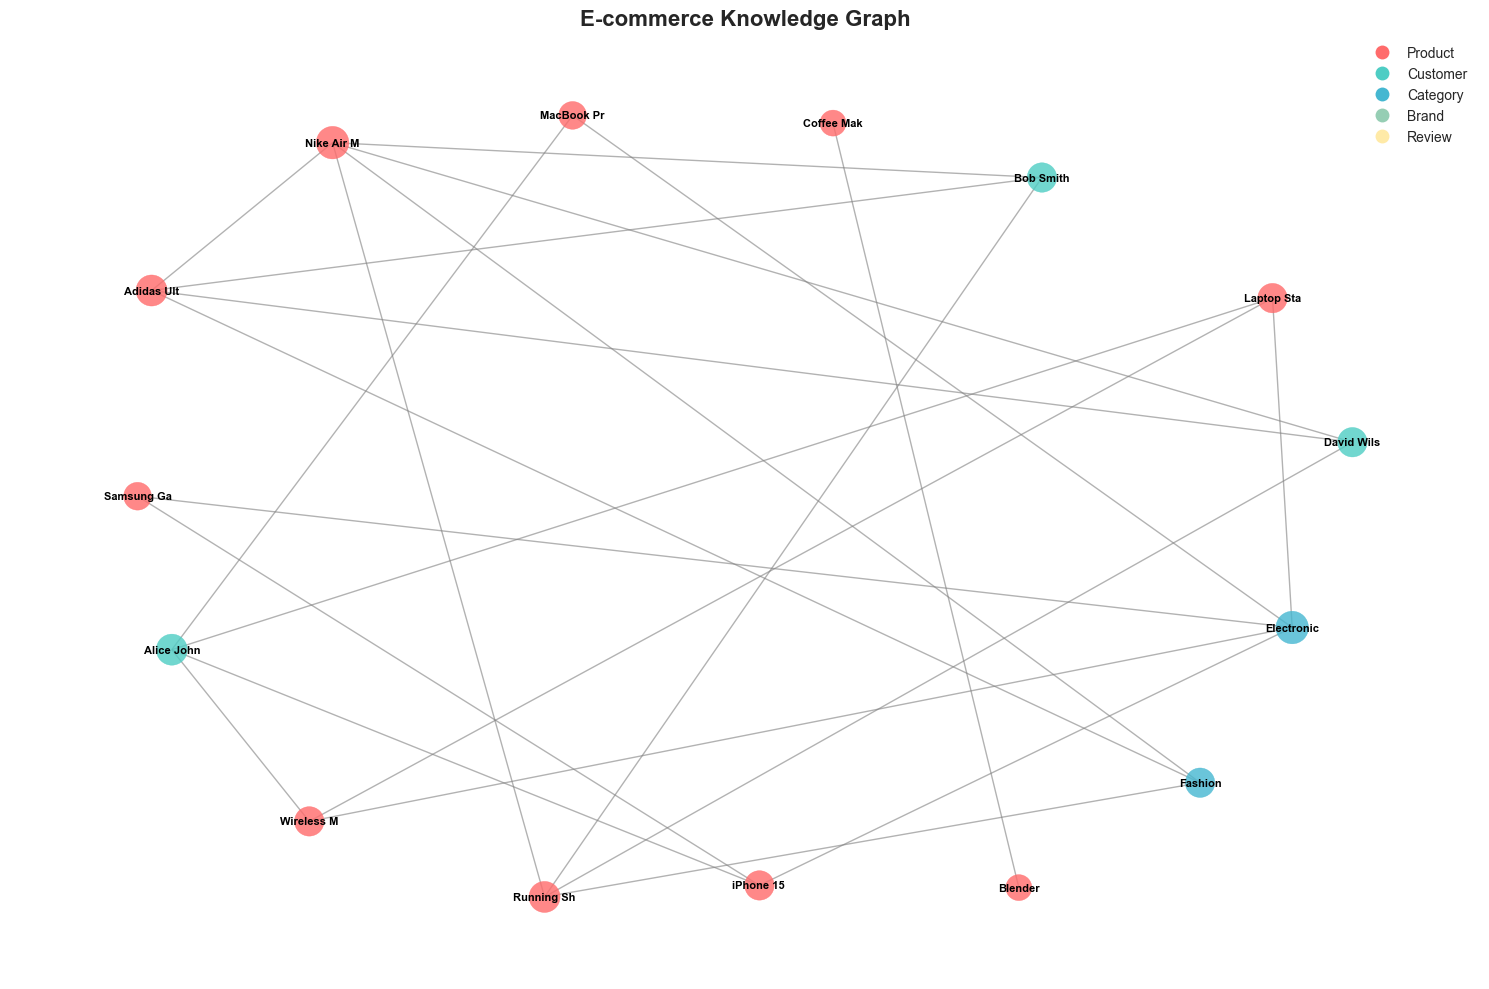

Graph Statistics:
Nodes: 15
Edges: 23
Average degree: 3.07
Connected components: 3


In [21]:
# Visualize the knowledge graph
def visualize_knowledge_graph(kg, max_nodes=20):
    """Visualize the knowledge graph with different entity types."""
    G = kg.to_networkx()
    
    # Create subgraph with limited nodes for better visualization
    if len(G.nodes()) > max_nodes:
        # Get most connected nodes
        node_degrees = dict(G.degree())
        top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        G = G.subgraph([node for node, _ in top_nodes])
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Color nodes by entity type
    node_colors = []
    node_sizes = []
    node_labels = {}
    
    color_map = {
        'Product': '#FF6B6B',
        'Customer': '#4ECDC4', 
        'Category': '#45B7D1',
        'Brand': '#96CEB4',
        'Review': '#FFEAA7'
    }
    
    for node in G.nodes():
        entity_type = G.nodes[node].get('type', 'Unknown')
        node_colors.append(color_map.get(entity_type, '#DDA0DD'))
        
        # Size based on degree
        degree = G.degree(node)
        node_sizes.append(300 + degree * 50)
        
        # Label with entity name
        if 'name' in G.nodes[node].get('properties', {}):
            node_labels[node] = G.nodes[node]['properties']['name'][:10]
        else:
            node_labels[node] = node
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.6,
                          width=1,
                          edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=8,
                           font_weight='bold')
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=10, label=entity_type)
                      for entity_type, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("E-commerce Knowledge Graph", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print graph statistics
    print(f"Graph Statistics:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Connected components: {nx.number_connected_components(G)}")

# Visualize the knowledge graph
visualize_knowledge_graph(kg, max_nodes=15)


## 2. Decision Making with Knowledge Graphs

### Graph-Based Recommendation System
Knowledge graphs enable sophisticated recommendation systems by:
- **Collaborative Filtering**: Finding similar users based on purchase patterns
- **Content-Based Filtering**: Recommending similar products
- **Hybrid Approaches**: Combining multiple signals for better recommendations

### Key Decision Making Applications:
1. **Product Recommendations**: Suggest products based on user behavior and product relationships
2. **Fraud Detection**: Identify suspicious patterns in transaction networks
3. **Risk Assessment**: Evaluate customer risk based on network connections
4. **Market Analysis**: Understand product relationships and market trends


In [23]:
# Graph-Based Recommendation System
class GraphRecommendationSystem:
    """Recommendation system based on knowledge graph analysis."""
    
    def __init__(self, knowledge_graph):
        self.kg = knowledge_graph
        self.G = knowledge_graph.to_networkx()
        
    def collaborative_filtering(self, customer_id, n_recommendations=5):
        """Find products based on similar customers."""
        # Get products purchased by the customer
        customer_products = set()
        for rel in self.kg.relationships:
            if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                customer_products.add(rel['object'])
        
        if not customer_products:
            return []
        
        # Find similar customers (those who bought similar products)
        similar_customers = {}
        for rel in self.kg.relationships:
            if (rel['predicate'] == 'purchased' and 
                rel['object'] in customer_products and 
                rel['subject'] != customer_id):
                
                if rel['subject'] not in similar_customers:
                    similar_customers[rel['subject']] = 0
                similar_customers[rel['subject']] += rel['weight']
        
        # Get products from similar customers
        recommendations = {}
        for similar_customer, similarity_score in similar_customers.items():
            for rel in self.kg.relationships:
                if (rel['subject'] == similar_customer and 
                    rel['predicate'] == 'purchased' and 
                    rel['object'] not in customer_products):
                    
                    product = rel['object']
                    if product not in recommendations:
                        recommendations[product] = 0
                    recommendations[product] += similarity_score * rel['weight']
        
        # Sort by score and return top recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def content_based_filtering(self, customer_id, n_recommendations=5):
        """Find products based on product similarity."""
        # Get products purchased by the customer
        customer_products = set()
        for rel in self.kg.relationships:
            if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                customer_products.add(rel['object'])
        
        if not customer_products:
            return []
        
        # Find similar products
        recommendations = {}
        for rel in self.kg.relationships:
            if (rel['predicate'] == 'similar_to' and 
                rel['subject'] in customer_products and 
                rel['object'] not in customer_products):
                
                product = rel['object']
                if product not in recommendations:
                    recommendations[product] = 0
                recommendations[product] += rel['weight']
        
        # Sort by score and return top recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def hybrid_recommendation(self, customer_id, n_recommendations=5, alpha=0.6):
        """Combine collaborative and content-based filtering."""
        collab_recs = dict(self.collaborative_filtering(customer_id, n_recommendations * 2))
        content_recs = dict(self.content_based_filtering(customer_id, n_recommendations * 2))
        
        # Combine scores
        hybrid_recs = {}
        all_products = set(collab_recs.keys()) | set(content_recs.keys())
        
        for product in all_products:
            collab_score = collab_recs.get(product, 0)
            content_score = content_recs.get(product, 0)
            
            # Normalize scores
            if collab_score > 0 and content_score > 0:
                hybrid_score = alpha * collab_score + (1 - alpha) * content_score
            else:
                hybrid_score = max(collab_score, content_score)
            
            hybrid_recs[product] = hybrid_score
        
        # Sort and return top recommendations
        sorted_recs = sorted(hybrid_recs.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def get_product_info(self, product_id):
        """Get detailed information about a product."""
        if product_id in self.kg.entities:
            return self.kg.entities[product_id]['properties']
        return None

# Initialize recommendation system
rec_system = GraphRecommendationSystem(kg)

# Test recommendations for different customers
customers = ['C001', 'C002', 'C003', 'C004', 'C005']

print("=== Graph-Based Recommendation System ===\n")

for customer_id in customers:
    customer_name = kg.entities[customer_id]['properties']['name']
    customer_profile = kg.entities[customer_id]['properties']['profile']
    
    print(f"Customer: {customer_name} ({customer_profile})")
    print("-" * 50)
    
    # Get different types of recommendations
    collab_recs = rec_system.collaborative_filtering(customer_id, 3)
    content_recs = rec_system.content_based_filtering(customer_id, 3)
    hybrid_recs = rec_system.hybrid_recommendation(customer_id, 3)
    
    print("Collaborative Filtering:")
    for product_id, score in collab_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\nContent-Based Filtering:")
    for product_id, score in content_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\nHybrid Recommendation:")
    for product_id, score in hybrid_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\n" + "="*60 + "\n")


=== Graph-Based Recommendation System ===

Customer: Alice Johnson (Tech Enthusiast)
--------------------------------------------------
Collaborative Filtering:
  - Samsung Galaxy S24 (Score: 1.190)

Content-Based Filtering:
  - Samsung Galaxy S24 (Score: 1.600)

Hybrid Recommendation:
  - Samsung Galaxy S24 (Score: 1.354)


Customer: Bob Smith (Fashion Lover)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: Carol Davis (Home Decorator)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: David Wilson (Fitness Enthusiast)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: Eva Brown (Gadget Collector)
--------------------------------------------------
Collaborative Filtering:
  - Laptop Stand (Score: 1.190)
  - Wireless Mouse (Sco